# MNIST with Keras

## Import Data

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


- **x_train, x_test**: array of grayscale image data, shape (num_samples, 28, 28)
- **y_train, y_test**: array of digit labels int[0..9] shape (num_samples)

In [2]:
n_class = 10
batch_size = 600
epoch_limit = 100

## Preprocessing

Reshape x from (28,28) to (764,)

In [3]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

Convert training and testing data to float and divide by 255 to make all values range between [0..1]

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

One-hot encoding for training and testing labels based on number of possible classes.

Example: 5 => (0, 0, 0, 0, 0, 1, 0, 0, 0, 0)

In [5]:
import keras

y_train = keras.utils.to_categorical(y_train, n_class)
y_test = keras.utils.to_categorical(y_test, n_class)

## Model

Use `Sequential` model from Keras to create multi-layer perceptron

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

model = Sequential()
model.add(Dense(196,
                activation='relu',
                kernel_initializer='he_uniform',
                input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(196,
                activation='relu',
                kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(98,
                activation='relu',
                kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(Dense(n_class,
                activation='softmax',
                kernel_initializer='glorot_normal'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 196)               153860    
_________________________________________________________________
dropout_1 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               38612     
_________________________________________________________________
dropout_2 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 98)                19306     
_________________________________________________________________
dropout_3 (Dropout)          (None, 98)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                990       
Total para

Weight initialization algorithm is determined by `kernel_initializer` param.
- `he_uniform` for layers with `relu` activation
- `glorot_normal` or _xavier_ for layers with `softmax` activation

This is chosen because on the research paper, _he_ focuses on relu and _xavier glorot_ focuses on sigmoid and softmax.

## Optimizers

Tested with two optimizers, adam and sgd, with adam winning by 1% increase in accuracy.

In [7]:
from keras import optimizers

adam = optimizers.Adam(lr=0.001,
                       beta_1=0.9,
                       beta_2=0.999,
                       epsilon=None,
                       decay=0.00001,
                       amsgrad=False)

sgd = optimizers.SGD(lr=0.001,
                     momentum=0.001,
                     decay=0.00001,
                     nesterov=False)

A higher value of learning rate (e.g. 0.1) will result in the model failing to converge.

## Training

In [8]:
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epoch_limit,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.6417 - acc: 0.8029 - val_loss: 0.2052 - val_acc: 0.9384
Epoch 2/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.2336 - acc: 0.9307 - val_loss: 0.1354 - val_acc: 0.9597
Epoch 3/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.1673 - acc: 0.9499 - val_loss: 0.1117 - val_acc: 0.9654
Epoch 4/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.1341 - acc: 0.9593 - val_loss: 0.0884 - val_acc: 0.9710
Epoch 5/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.1126 - acc: 0.9652 - val_loss: 0.0827 - val_acc: 0.9740
Epoch 6/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.0972 - acc: 0.9696 - val_loss: 0.0804 - val_acc: 0.9747
Epoch 7/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.0829 - acc: 0.9745 - val_loss: 0.0725 - 

## Testing Scores

In [9]:
score = model.evaluate(x_test, y_test,
                       verbose=1)

print('Test Loss = {}, Test Accuracy = {}'.format(score[0], score[1]))

10000/10000 [==============================] - 1s 60us/step
Test Loss = 0.0825519267771743, Test Accuracy = 0.9843


## Test Case Analysis

First, we need to detect which test cases failed to be predicted

In [59]:
import numpy as np

y_test_prediction = model.predict(x_test, verbose=1)

# Round to turn predictions to 0 and 1
y_test_prediction = np.round(y_test_prediction)

failed_indices = []
false_count = 0
for i in range (len(y_test)):
    for j in range (n_class):
        if y_test_prediction[i][j] != y_test[i][j]:
            failed_indices.append(i)
            false_count += 1
            break
            
print("Total of {} failed test case".format(false_count))

10000/10000 [==============================] - 0s 38us/step
Total of 161 failed test case


The following code will visualize 9 random data that is **wrongly** classified

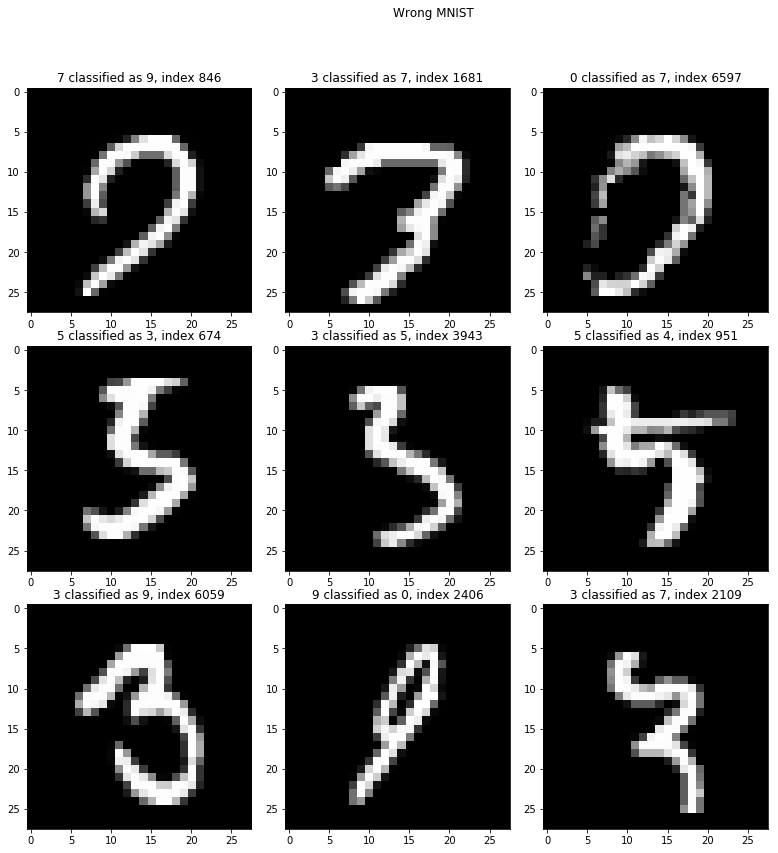

In [77]:
import matplotlib.pyplot as plt
import random

figure, ax = plt.subplots(3,3, figsize=(12, 12))
figure.suptitle('Wrong MNIST')
figure.tight_layout(pad=0.3, rect=[0,0,0.9,0.9])

used_indices = []
for x, y in [(i, j) for i in range(3) for j in range(3)]:
    index = random.choice(failed_indices)
    # Check if the randomized index has been used this time
    while index in used_indices:
        index = random.choice(failed_indices)
    used_indices.append(index)
    ax[x, y].imshow(x_test[index].reshape((28,28)), cmap='gray')
    ax[x, y].set_title('{} classified as {}, index {}'.format(np.argmax(y_test[index]), np.argmax(y_test_prediction[index]), index))

For comparison, the following code will visualize 9 random data that is **correctly** classified.

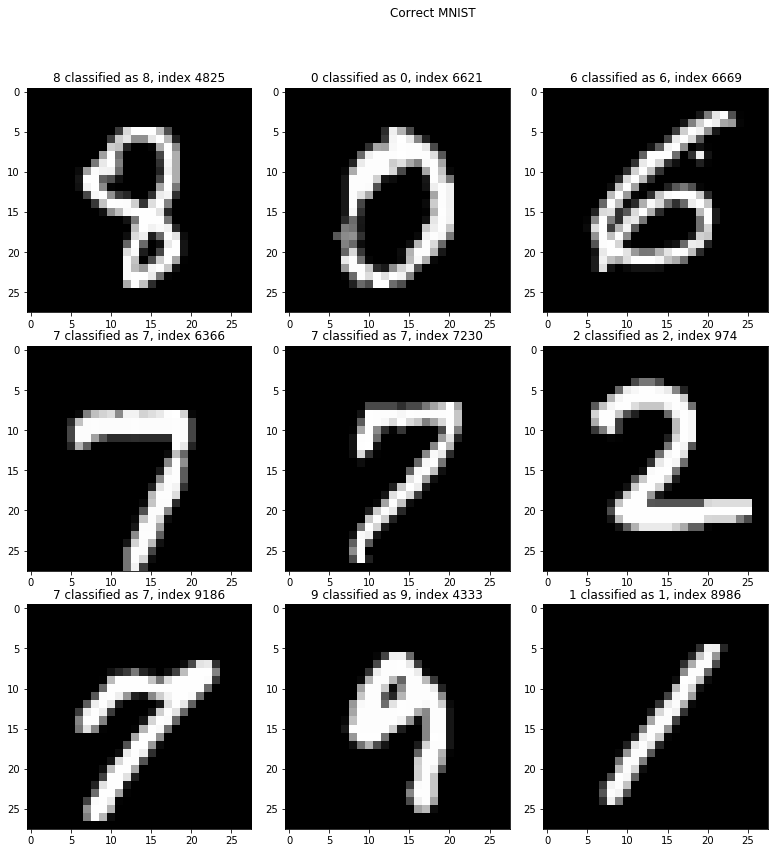

In [78]:
from random import randint

figure, ax = plt.subplots(3,3, figsize=(12, 12))
figure.suptitle('Correct MNIST')
figure.tight_layout(pad=0.3, rect=[0,0,0.9,0.9])

used_indices = []
for x, y in [(i, j) for i in range(3) for j in range(3)]:
    index = randint(0,len(y_test))
    # Check if the randomized index has been used this time
    while index in failed_indices or index in used_indices:
        index = randint(0,len(y_test))
    used_indices.append(index)
    ax[x, y].imshow(x_test[index].reshape((28,28)), cmap='gray')
    ax[x, y].set_title('{} classified as {}, index {}'.format(np.argmax(y_test[index]), np.argmax(y_test_prediction[index]), index))

### Acceptable Misclassification

The following is a collection of wrong classification that is "acceptable". The data is quite hard to be classified even by humans and it is considered acceptable for the model to classify it wrongly.

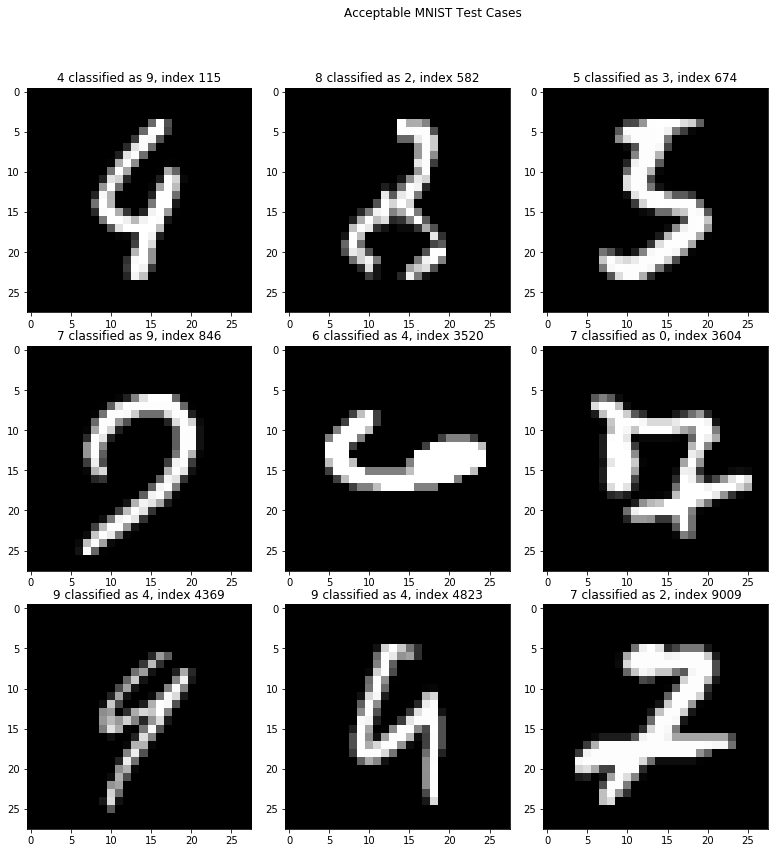

In [79]:
figure, ax = plt.subplots(3,3, figsize=(12, 12))
figure.suptitle('Acceptable MNIST Test Cases')
figure.tight_layout(pad=0.3, rect=[0,0,0.9,0.9])

it = 0
acceptable_index = [115, 582, 674, 846, 3520, 3604, 4369, 4823, 9009]

for x, y in [(i, j) for i in range(3) for j in range(3)]:
    index = acceptable_index[it] 
    it += 1
    ax[x, y].imshow(x_test[index].reshape((28,28)), cmap='gray')
    ax[x, y].set_title('{} classified as {}, index {}'.format(np.argmax(y_test[index]), np.argmax(y_test_prediction[index]), index))

These misclassifications are quite acceptable because the 9s do actually look like 4s and vice versa. A very extreme example is the one in the 2nd row and 2nd column where the 6 is angled nearly 90 degrees.

### Less Acceptable Misclassification

The following is a collection of wrong classification that is less acceptable. The data is in decent form for human and the model should've been able to classify it correctly.

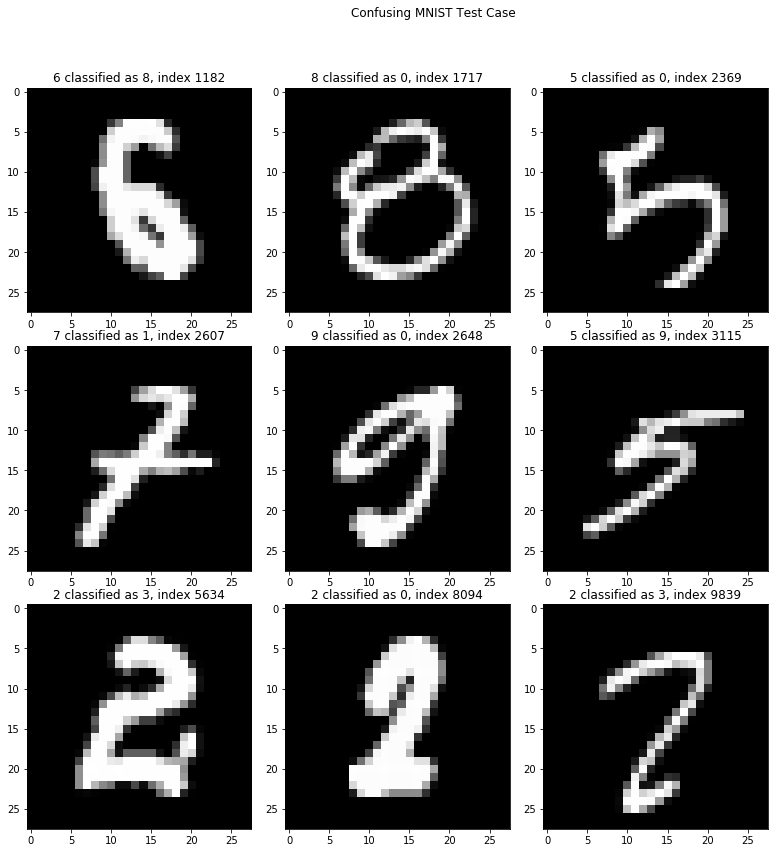

In [80]:
figure, ax = plt.subplots(3,3, figsize=(12, 12))
figure.suptitle('Less Acceptable MNIST Test Case')
figure.tight_layout(pad=0.3, rect=[0,0,0.9,0.9])

it = 0
acceptable_index = [1182, 1717, 2369, 2607, 2648, 3115, 5634, 8094, 9839]

for x, y in [(i, j) for i in range(3) for j in range(3)]:
    index = acceptable_index[it] 
    it += 1
    ax[x, y].imshow(x_test[index].reshape((28,28)), cmap='gray')
    ax[x, y].set_title('{} classified as {}, index {}'.format(np.argmax(y_test[index]), np.argmax(y_test_prediction[index]), index))

A preliminary analysis is because the numbers are slightly angled and/or compressed. These abnormalities affect the model's ability to classify them correctly.